In [8]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import pearson_correlation as ps
import pre_processing as pre
import graphic as gr
import download_file as dl
from pca import pca 
import matplotlib.pyplot as plt  
from statsmodels.graphics.gofplots import qqplot 
plt.rcParams["figure.figsize"] =(22,15)

In [9]:
#----------------------------------------READ-DATA-----------------------------------------------------
first_column = ['Time','VCPM']
columns = [first_column[x] if x<2 else f'Vi{x}' for x in range(16386)] 
data = dl.read_file('DATASET03.csv',url='http://ltu.diva-portal.org/smash/get/diva2:1244889',separator=',',columns=columns) 
 
#----------------------------------------READ-DATA-----------------------------------------------------
 

In [10]:
data.head(5000)

,Time,VCPM,Vi2,Vi3,Vi4,Vi5,Vi6,Vi7,Vi8,Vi9,...,Vi16376,Vi16377,Vi16378,Vi16379,Vi16380,Vi16381,Vi16382,Vi16383,Vi16384,Vi16385
0,0.000000,1100.2980,-1.322455,-1.444341,1.373952,0.257178,0.734968,0.729179,-1.732295,0.448538,...,1.174365,1.410213,1.750882,1.000069,0.110916,-0.950096,-1.225861,-1.697253,-1.214282,-1.212149
1,0.000915,910.2272,-0.937603,-0.350420,0.123714,-1.080818,0.806271,0.311722,-0.350420,0.527459,...,0.914140,0.681643,-0.353772,-0.122190,0.234934,0.866300,0.008227,-0.080444,0.392471,1.193257
2,0.001825,874.5125,0.398565,0.712419,-1.090873,0.011579,1.110984,-0.285516,-0.474134,0.283993,...,0.424161,0.260225,-0.510395,-0.047535,0.750813,-0.699317,-0.441834,0.963808,0.288868,-0.929071
3,0.005484,860.4854,0.990318,-1.895316,0.384853,1.577805,-0.350725,-0.268452,-0.405269,-0.400088,...,0.321168,-0.254436,0.062771,0.111525,-0.445795,-0.155099,0.028034,-0.081054,-0.450671,-0.532639
4,0.005596,1101.7020,-0.184656,0.312636,1.250848,-1.128048,-2.019030,-0.529287,2.424603,0.521060,...,-0.710286,1.241402,0.791340,-3.423758,0.075264,2.087590,-0.337013,-0.570118,2.378287,1.534840
5,0.005653,1102.7690,0.732835,1.717364,1.568968,-0.230973,2.220445,1.533622,-2.592500,-2.201248,...,1.373647,1.170099,1.766422,2.605298,1.765813,0.954057,0.196235,-0.108783,0.012493,-0.978434
6,0.005735,1112.5690,-2.088504,0.132855,3.554784,1.171013,-0.576213,-0.984224,-2.952671,-0.271804,...,0.184961,-1.746616,-2.626018,-2.131469,-1.673485,-1.920303,-1.193257,-0.510699,0.853197,1.102452
7,0.005754,1034.8230,0.104212,1.636005,-1.438856,-1.849304,1.966314,1.159738,-0.186789,-0.417762,...,-0.362609,1.387055,1.351098,-0.408620,-1.026579,-0.224878,0.286126,-1.804512,-1.783791,-1.036025
8,0.005787,1045.8830,-0.791950,-0.167288,1.664953,1.786838,0.211166,-0.753251,0.695356,2.846935,...,-2.820425,-2.694274,-1.100319,-1.450740,-1.027188,-1.690244,-1.577500,-0.950400,-2.955109,-1.286194
9,0.005814,1005.3290,0.858072,0.801396,0.857768,0.758431,0.322691,1.318494,1.572930,0.445491,...,1.036330,1.195999,1.308134,1.278272,1.204531,1.412650,1.597611,0.615521,0.337318,-0.502167


In [11]:
segment_signal = data.iloc[:,2:]
new_signal = segment_signal.iloc[:,:12800]
#Determine variables  
print(new_signal.shape) 
N = len(new_signal.columns)*len(new_signal)#length of the array
Fs = 12800 	#sample rate (Hz)
T = 1/Fs;
print("# Samples:",N)


(3005, 12800)
# Samples: 38464000


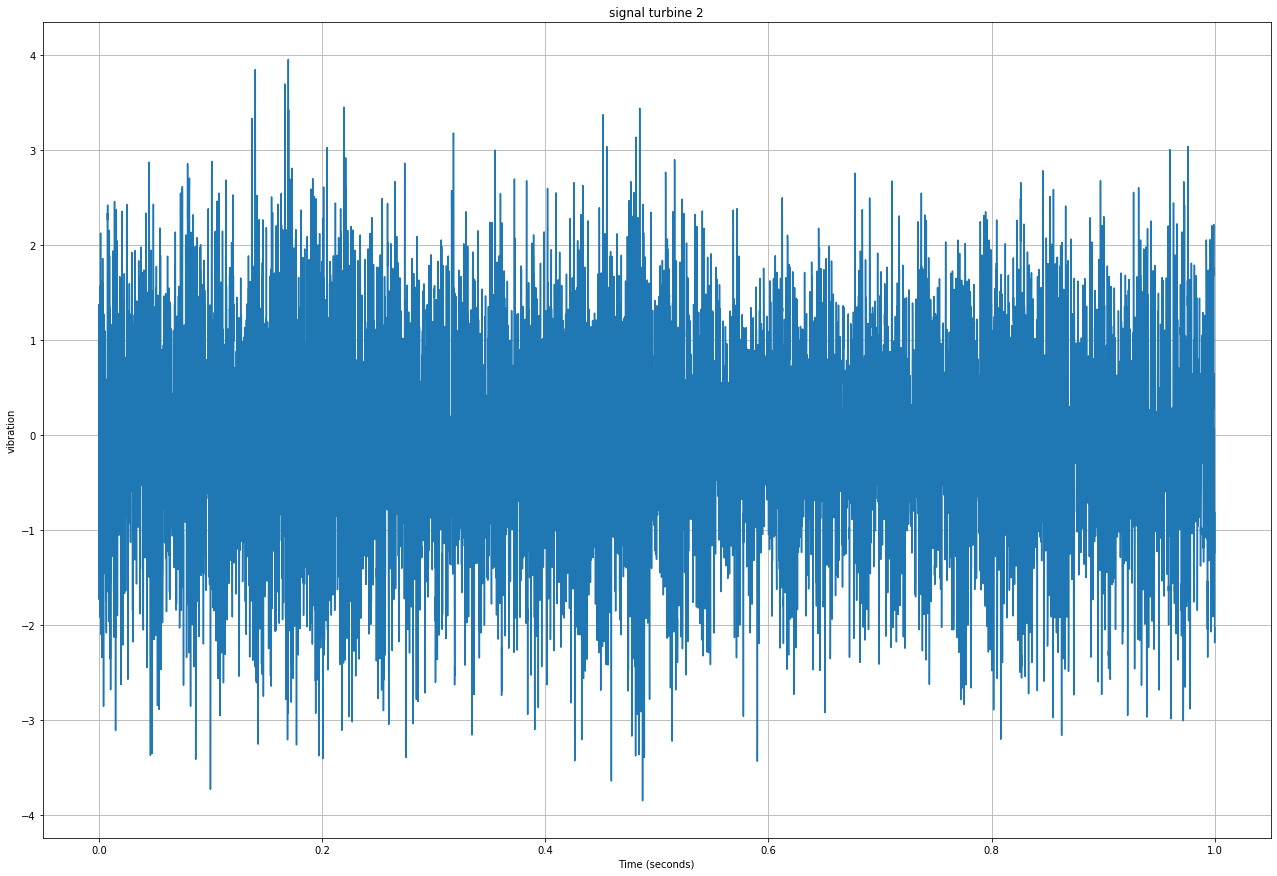

In [26]:

#Plot Data
time = [7.8125e-05*x for x in range(len(new_signal.iloc[0,:12800]))] 
plt.figure(1)  
plt.plot(time, new_signal.iloc[0,:12800])
plt.xlabel('Time (seconds)')
plt.ylabel('vibration')
plt.title('signal turbine 2')
plt.grid()  
plt.show()  
time = [7.8125e-05*x*(t+1) for t in range(len(new_signal)) for x in range(len(new_signal.iloc[t,:12800]))] 

In [6]:
signal_for_day =[]
for i in range (0, 3005):
    signal_for_day.append(new_signal.iloc[i,:])  

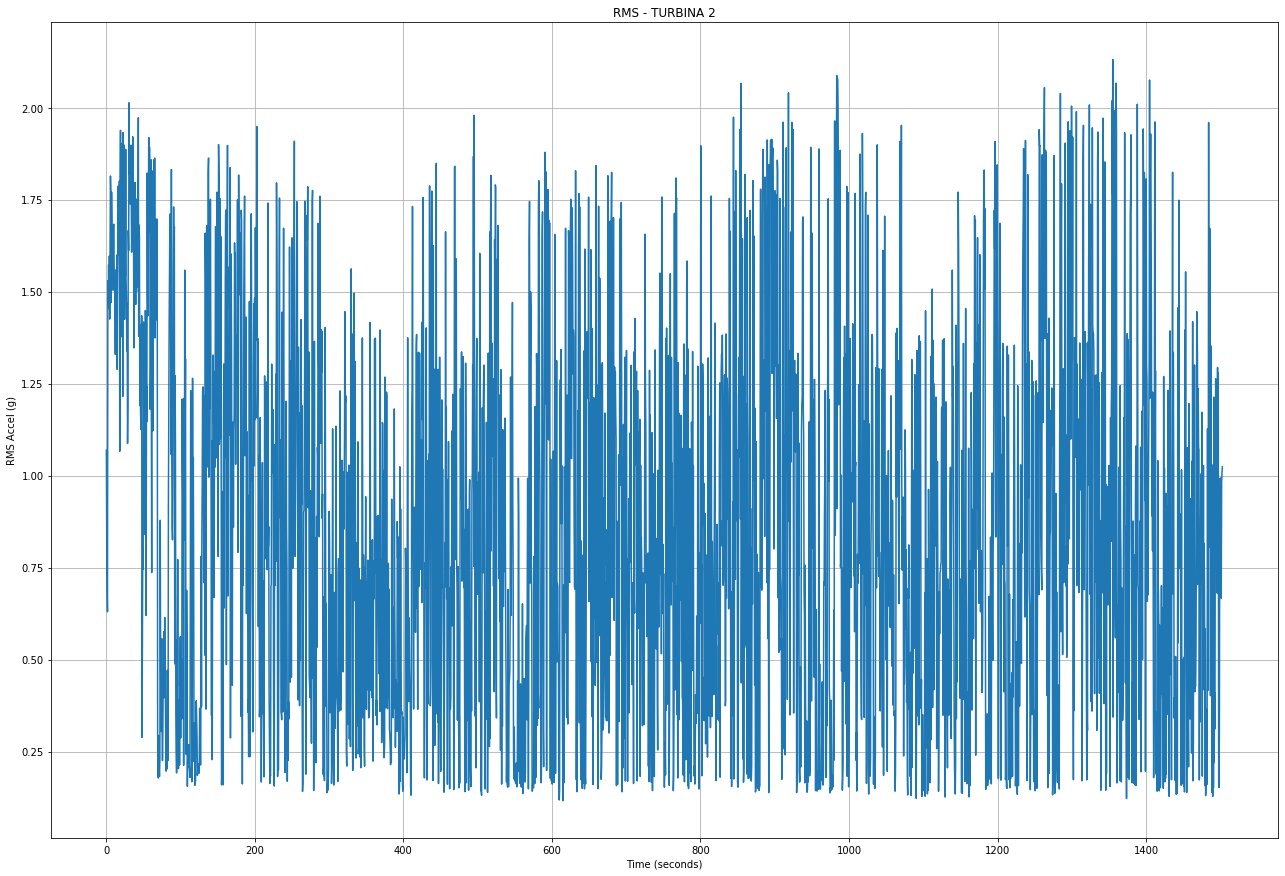

In [27]:

w = np.int(np.floor(Fs)); #width of the window for computing RMS
steps =  np.int_(np.floor(N/w)); #Number of steps for RMS
t_RMS = np.zeros((steps,1)); #Create array for RMS time values
x_RMS = np.zeros((steps,1)); #Create array for RMS values  
for i in range (0, steps):
    t_RMS[i] = np.mean(time[(i*w):((i+1)*w)])
    x_RMS[i] = np.sqrt(np.mean(new_signal.iloc[i,:]**2))   
 
plt.figure(2)  
plt.plot(t_RMS, x_RMS)
plt.xlabel('Time (seconds)')
plt.ylabel('RMS Accel (g)')
plt.title('RMS - TURBINA 2')
plt.grid()  

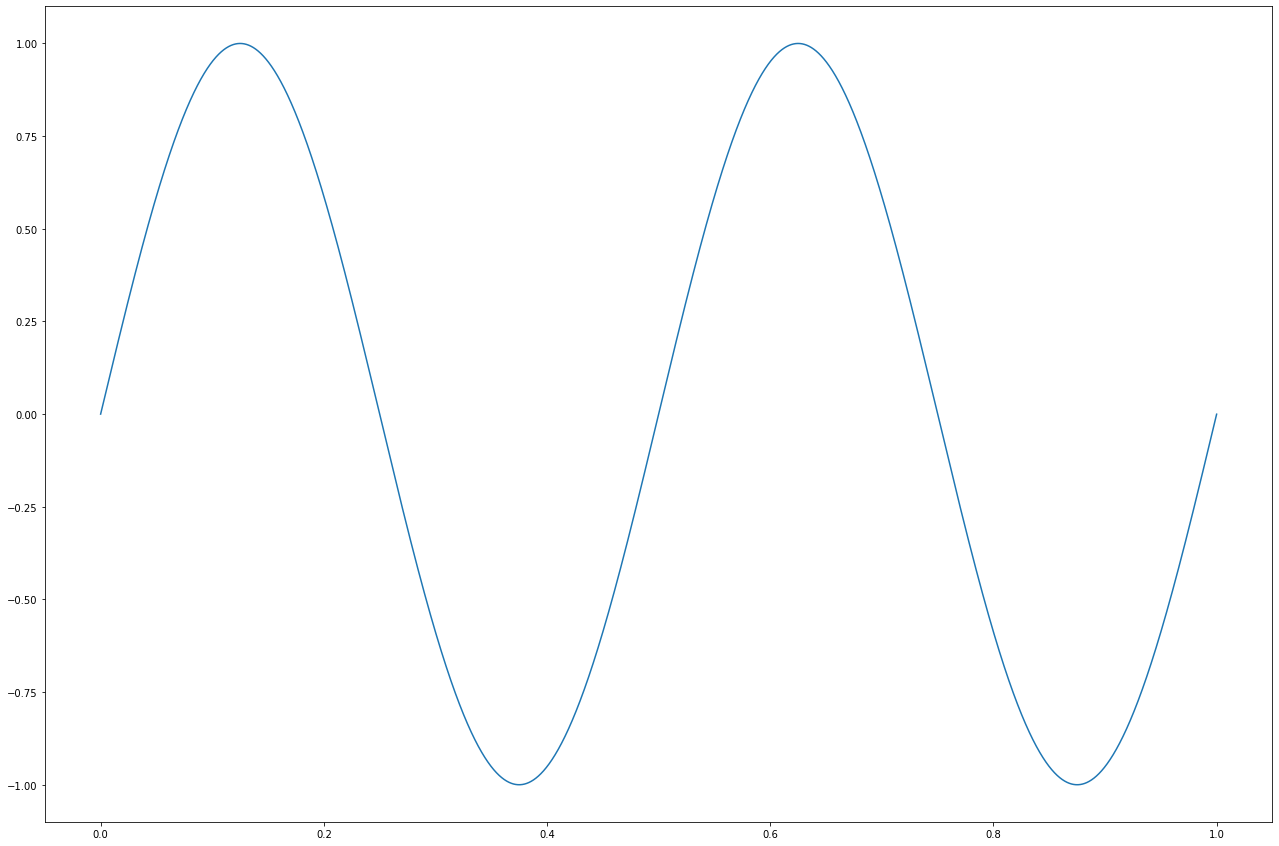

709467
-0.2966606315455461
-0.29693274353205007
-0.2972048314083621
-0.29747689515239273
-0.2977489347420494
-0.29802095015524316
-0.2982929413698853
-0.2985649083638944
-0.29883685111518543
-0.29910876960167754
-0.2993806638012899
-0.2996525336919488
-0.2999243792515773
-0.30019620045810225
-0.3004679972894525
-0.30073976972355715
-0.30101151773835233
-0.3012832413117711
-0.30155494042175013
-0.30182661504622654
-0.3020982651631443
-0.30236989075044457
-0.3026414917860719
-0.3029130682479713
-0.30318462011409497
-0.3034561473623917
-0.30372764997081425
-0.3039991279173156
-0.30427058117985584
-0.30454200973639184
-0.30481341356488445
-0.30508479264329624
-0.30535614694959023
-0.3056274764617366
-0.3058987811577023
-0.30617006101545646
-0.30644131601297514
-0.30671254612823146
-0.30698375133920225
-0.3072549316238663
-0.30752608696020445
-0.30779721732619786
-0.30806832269983486
-0.3083394030591007
-0.3086104583819826
-0.30888148864647486
-0.309152493830569
-0.30942347391225994
-0.3096

In [25]:
import numpy as np
from matplotlib import pyplot as plt

SAMPLE_RATE = 44100  # Hertz
DURATION = 1  # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()
 

In [9]:
plt.figure(2)  
plt.plot(t_RMS, signal_for_day)
plt.xlabel('Time (seconds)')
plt.ylabel('RMS Accel (g)')
plt.title('RMS - TURBINA 2')
plt.grid() 

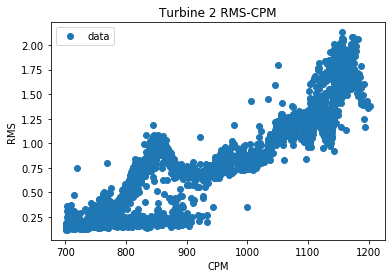

In [12]:
cpm = data.iloc[:,1:2]
len(cpm)
#scatter plot x - column 0, y - column 1, shown with marker o
plt.plot(cpm,x_RMS, 'o', label = 'data')
#create legend in case you have more than one series
plt.legend() 
plt.title('Turbine 2 RMS-CPM')
plt.xlabel('CPM')
plt.ylabel('RMS')
plt.show()

In [13]:
(3005/2)

1502.5

In [14]:
1502.5/365

4.116438356164384

In [15]:
5000*16384

81920000

In [16]:
for row in range(len(data)):
   print(f' row {row} {data.iloc[row,2:].mean()}')

1392522261
 row 2389 0.0004603058973984206
 row 2390 0.0005228703030084802
 row 2391 1.2832770472898103e-05
 row 2392 0.00037501446929866233
 row 2393 3.5076239292653605e-05
 row 2394 0.0003581644837211632
 row 2395 0.00045926439718612776
 row 2396 0.0002537912838747082
 row 2397 0.0004793504727089587
 row 2398 0.0004813590802612514
 row 2399 0.00011902859569094815
 row 2400 0.00020253459485531505
 row 2401 0.00010087673484804284
 row 2402 0.0001863169486924221
 row 2403 0.00034455058808901314
 row 2404 0.00030768891986098466
 row 2405 0.000586587798139273
 row 2406 0.0002662892864222447
 row 2407 0.00016585890880804516
 row 2408 7.443006874297063e-05
 row 2409 0.0001689834094449616
 row 2410 0.0001357669919599576
 row 2411 0.0002546096054700693
 row 2412 0.0002687070547722256
 row 2413 0.00014357824355215425
 row 2414 7.8335694539103e-05
 row 2415 0.0003268450844799986
 row 2416 8.525423166361006e-05
 row 2417 0.00021309838272288995
 row 2418 0.0004679683632460448
 row 2419 0.00012051

In [17]:
data.std()

Time         1.150467
VCPM       158.985649
Vi2          0.960748
Vi3          0.987841
Vi4          1.004685
Vi5          1.003754
Vi6          1.048433
Vi7          1.030306
Vi8          0.985966
Vi9          0.993462
Vi10         0.988894
Vi11         0.986063
Vi12         1.006082
Vi13         1.032236
Vi14         1.009747
Vi15         0.985297
Vi16         1.010384
Vi17         1.018269
Vi18         0.995948
Vi19         1.013036
Vi20         1.012487
Vi21         0.959052
Vi22         0.981668
Vi23         0.995016
Vi24         0.997461
Vi25         0.999918
Vi26         1.007777
Vi27         1.010489
Vi28         1.020018
Vi29         0.997219
              ...    
Vi16356      1.018665
Vi16357      0.997697
Vi16358      0.972180
Vi16359      1.002294
Vi16360      1.017566
Vi16361      0.998343
Vi16362      1.012575
Vi16363      1.028514
Vi16364      1.015101
Vi16365      1.008188
Vi16366      1.005124
Vi16367      0.989681
Vi16368      0.989193
Vi16369      0.989455
Vi16370   

In [18]:

#----------------------------------------PEARSON-----------------------------------------------------
pearson_matrix = ps.pearson_correlation(wind_turbine)  
result = ps.transform_value(pearson_matrix)
result=result.astype(float)
display(pearson_matrix)
#gr.seaborn_pearson_plot(result)  
#----------------------------------------PEARSON-----------------------------------------------------

NameError: name 'wind_turbine' is not defined

In [ ]:

#-----------------------------------FILLNaNVALUES AND SELECT TARGET----------------------------------
wind_turbine = pre.fill_NaN_values(wind_turbine.copy())
y_train_old =pre.select_y(wind_turbine)
wind_turbine = wind_turbine.drop('Rbt_avg',axis=1)   

#-----------------------------------FILLNaNVALUES AND SELECT TARGET----------------------------------
